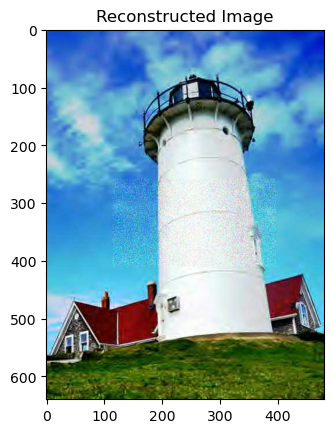

In [4]:
import numpy as np
from PIL import Image
from scipy.fftpack import dct, idct
import matplotlib.pyplot as plt

# Function to apply DCT to 2D array
def apply_dct(image):
    return dct(dct(image, axis=0, norm='ortho'), axis=1, norm='ortho')

# Function to apply inverse DCT to 2D array
def apply_idct(image):
    return idct(idct(image, axis=0, norm='ortho'), axis=1, norm='ortho')

# Function to generate indices to chunk an array into 8x8 blocks
def chunker(seq_shape, size):
    for pos in range(0, seq_shape[0], size):
        for pos2 in range(0, seq_shape[1], size):
            yield (pos, pos2)

# Function to quantize DCT coefficients
def quantize(block, quant_matrix):
    return (block / quant_matrix).round().astype(int)

# Function to dequantize DCT coefficients
def dequantize(block, quant_matrix):
    return (block * quant_matrix).astype(float)

# Quantization Matrix for JPEG
quant = np.array([[16, 11, 10, 16, 24, 40, 51, 61],
                  [12, 12, 14, 19, 26, 58, 60, 55],
                  [14, 13, 16, 24, 40, 57, 69, 56],
                  [14, 17, 22, 29, 51, 87, 80, 62],
                  [18, 22, 37, 56, 68, 109, 103, 77],
                  [24, 35, 55, 64, 81, 104, 113, 92],
                  [49, 64, 78, 87, 103, 121, 120, 101],
                  [72, 92, 95, 98, 112, 100, 103, 99]])

# Load the image and convert to YCbCr
image = Image.open(r'C:\Program Files\MATLAB\R2023a\toolbox\images\imdata\DistortedImage.png')  # Replace with the actual image path
ycbcr = image.convert('YCbCr')
np_img = np.array(ycbcr, dtype=float)

# Process each channel separately (Y, Cb, Cr)
channels_dct = []
for channel in range(3):
    channel_data = np_img[:, :, channel] - 128
    rows, cols = channel_data.shape
    compressed_channel = np.zeros_like(channel_data)
    
    for (i, j) in chunker(channel_data.shape, 8):
        block = channel_data[i:i+8, j:j+8]
        dct_block = apply_dct(block)
        quantized_block = quantize(dct_block, quant)
        compressed_channel[i:i+8, j:j+8] = quantized_block
        
    channels_dct.append(compressed_channel)

# Reconstructing the image from the DCT coefficients
reconstructed_channels = []
for compressed_channel in channels_dct:
    channel_data = np.zeros_like(compressed_channel)
    
    for (i, j) in chunker(compressed_channel.shape, 8):
        quantized_block = compressed_channel[i:i+8, j:j+8]
        dequantized_block = dequantize(quantized_block, quant)
        idct_block = apply_idct(dequantized_block)
        channel_data[i:i+8, j:j+8] = idct_block
    
    reconstructed_channels.append(channel_data + 128)

# Convert the YCbCr image back to RGB and save/display it
reconstructed_image = np.stack(reconstructed_channels, axis=2).clip(0, 255).astype(np.uint8)
reconstructed_image = Image.fromarray(reconstructed_image, mode='YCbCr').convert('RGB')
# Display the reconstructed image
plt.imshow(reconstructed_image)
plt.title('Reconstructed Image')
plt.show()

In [5]:
# Assuming np_img is the original and reconstructed_image is the Y channel of the reconstructed image
original = np_img[:, :, 0]  # Extract the Y channel if it's YCbCr or use the image directly if grayscale
reconstructed = np.array(reconstructed_image.convert('YCbCr'))[:, :, 0]  # Convert to YCbCr and use the Y channel

# Calculate MSE
mse = np.mean((original - reconstructed) ** 2)

# Calculate PSNR
if mse == 0:
    # MSE is zero means no noise is present in the signal .
    # Therefore PSNR is infinite (log of zero is undefined)
    psnr = float('inf')
else:
    max_pixel = 255.0
    psnr = 20 * np.log10(max_pixel / np.sqrt(mse))

print(f"MSE: {mse}")
print(f"PSNR: {psnr} dB")


MSE: 30.8700390625
PSNR: 33.235431818355245 dB
